In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gprot.summary import summarize_fits
from gprot.aigrain import AigrainTruths

resultsdir = '../results_bestchunks'
df = summarize_fits(resultsdir, truths='aigrain')
df = df.join(AigrainTruths().df)

df_acf = pd.read_table('../acf_all.txt', delim_whitespace=True)
df_acf = df_acf.sort_values(['star', 'quality'], ascending=[True, False]).groupby('star').first()
df_acf = df_acf.join(AigrainTruths().df)
df_acf['P_MEAN'] = (df_acf.P_MIN + df_acf.P_MAX)/2.

In [76]:
df_acf[['prot','tau','quality','P_MIN','P_MAX']].head(10)

,prot,tau,quality,P_MIN,P_MAX
star,,,,,
0,4.906,0.281,14.01,1.126183,1.945763
1,1.840,2.995,74.80,1.655854,2.304845
2,21.482,8.757,93.77,17.040000,17.040000
3,43.741,95.996,448.65,42.377017,50.873710
4,0.593,0.103,32.82,50.786350,93.208385
5,24.160,23.493,213.89,23.640000,23.640000
6,34.870,27.129,182.17,36.890488,48.809294
7,4.047,0.198,35.57,29.398169,31.783883
8,26.081,53.618,287.06,23.528024,30.328238


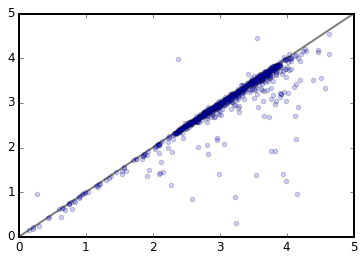

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

q = 'tau > 0.5*prot'

fig, ax = plt.subplots(1,1)
points = ax.scatter(np.log(df_acf.query(q)['P_MEAN']), np.log(df_acf.query(q).prot), 
                    alpha=0.2)
ax.plot(range(6), range(6), 'k', lw=2, alpha=0.5, zorder=0)
ax.set_xlim((0,5))
ax.set_ylim((0,5))
tooltip = plugins.PointLabelTooltip(points, labels=['{}: {:.2f}'.format(i, df_acf.ix[i, 'P_MEAN'])
                                                    for i in df_acf.query(q).index])
plugins.connect(fig, tooltip)

In [79]:
len(df_acf.query(q))

795

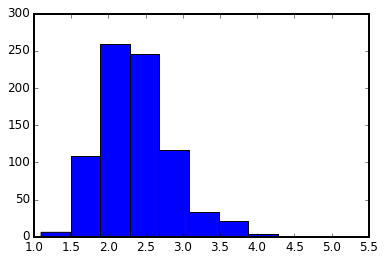

In [82]:
plt.hist(np.log10(df_acf.query(q)['quality']));

In [5]:
np.log(100)

4.6051701859880918

In [28]:
len(df_acf.index)

1000

In [32]:
df_acf.ix[105]

acf_prot           6.279100e+01
acf_height         4.160000e-01
N                  1.050000e+02
AR                 9.510000e-01
CLEN               8.724000e+00
COVER              7.370000e-01
LMIN               3.127300e+01
LMAX               5.634300e+01
R                  0.000000e+00
SINI               1.400000e-01
PEQ                1.310000e+00
PPOL               1.682451e+00
A_MED             -3.530000e+00
TAU                4.820000e+00
NSPOT              5.460000e+02
DELTA_OMEGA        1.061782e+00
DELTA_OMEGA_REL    2.213740e-01
OMEGA_EQ           4.796325e+00
OMEGA_POL          3.734543e+00
OMEGA_MIN          4.060679e+00
OMEGA_MAX          4.510194e+00
P_MIN              1.393108e+00
P_MAX              1.547324e+00
AMP                1.991325e-03
KID                4.148380e+06
Name: 105, dtype: float64

In [3]:
# q = 'DELTA_OMEGA==0'
# df = df.query(q)

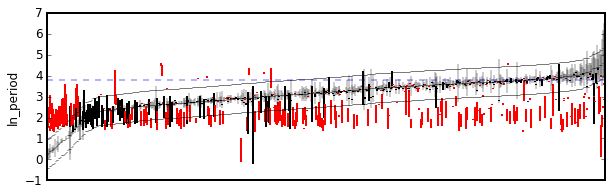

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import mpld3
from mpld3 import plugins
mpld3.enable_notebook()

inds = df.index[np.argsort(df.aigrain_p_mean)]
fig, ax = plt.subplots(1, 1, figsize=(10,3))
lines = []
labels = []
colors = []
ln2 = np.log(2)
di = 0.5
bad_shortP = []
bad_longP = []
highlight = [466]
for i,ix in enumerate(inds):
    ymin, ymax = df.ix[ix, ['aigrain_p_min', 'aigrain_p_max']]
    ymean = (ymin + ymax)/2.
    ax.plot([i,i], [ymin, ymax], color='k', alpha=0.2)
    ax.plot([i-di, i+di], [ymean, ymean], color='k', lw=1, alpha=0.3)
    ax.plot([i-di, i+di], [ymean-ln2, ymean-ln2], color='k', lw=1, alpha=0.3)
    ax.plot([i-di, i+di], [ymean+ln2, ymean+ln2], color='k', lw=1, alpha=0.3)
#     tau, peq = df.ix[ix, ['TAU', 'PEQ']]
#     y_tau = np.log(tau*peq)
#     ax.plot([i-0.5, i+1.5], [y_tau, y_tau], color='k', lw=1)
    
    
    ylo, yhi = df.ix[ix, ['ln_period_16', 'ln_period_84']]
    if ix in highlight:
        color = 'b'
    elif (yhi < ymin) or (ylo > ymax):
        color='r'
        if yhi < ymin:
            bad_longP.append(ix)
        else:
            bad_shortP.append(ix)
    else:
        color='k'
    lines.append(([i,ylo], [i,yhi]))
    colors.append(color)
    label = '{}: AMP={:.2e}'.format(ix, df.ix[ix, 'AMP'])
    labels.append(label)

collection = LineCollection(lines, colors=colors, linewidths=2)
ax.add_collection(collection)
ax.set_xlim((-0.5, i+0.5))
ax.set_xticks([]);
ax.set_ylabel('ln_period');
ax.plot([-0.5, i+0.5], [np.log(45), np.log(45)], ls='--', color='b', alpha=0.3);

tooltip = mpld3.plugins.PointLabelTooltip(collection, labels=labels)
plugins.connect(fig, tooltip)

In [9]:
np.savetxt('bad_shortP.list', bad_shortP, fmt='%i')
np.savetxt('bad_longP.list', bad_longP, fmt='%i')

In [11]:
bad_longP

[779,
 336,
 376,
 542,
 301,
 640,
 497,
 736,
 347,
 552,
 281,
 487,
 271,
 397,
 387,
 536,
 458,
 47,
 112,
 268,
 108,
 443,
 94,
 503,
 166,
 646,
 540,
 689,
 28,
 64,
 816,
 451,
 732,
 60,
 454,
 245,
 440,
 406,
 2,
 413,
 394,
 143,
 140,
 868,
 377,
 228,
 766,
 68,
 110,
 412,
 308,
 695,
 104,
 25,
 313,
 481,
 583,
 77,
 231,
 470,
 426,
 76,
 191,
 33,
 269,
 423,
 556,
 782,
 936,
 655,
 967,
 482,
 329,
 157,
 433,
 553,
 768,
 647,
 430,
 743,
 710,
 221,
 551,
 256,
 359,
 460,
 146,
 246,
 128,
 11,
 591,
 17,
 713,
 203,
 307,
 389,
 135,
 811,
 368,
 884,
 333,
 576,
 267,
 300,
 167,
 342,
 475,
 139,
 130,
 335,
 704,
 653,
 761,
 260,
 450,
 343,
 98,
 7,
 701,
 499,
 31,
 522,
 199,
 349,
 72,
 80,
 26,
 296,
 164,
 48,
 122,
 994,
 9,
 326,
 456,
 152,
 40,
 207,
 153,
 249,
 853,
 111,
 792,
 999,
 69,
 201,
 289,
 882,
 447,
 126,
 997,
 468,
 894,
 669,
 530,
 520,
 694,
 217,
 383,
 120,
 192,
 119,
 407,
 318,
 253,
 115,
 399,
 145,
 176,
 608,
 29,
 

In [6]:
len(bad)

352

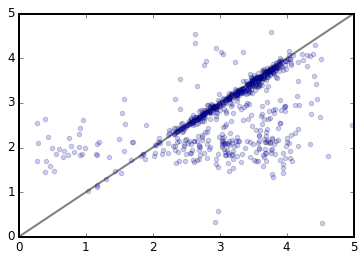

In [5]:
fig, ax = plt.subplots(1,1)
points = ax.scatter(df.aigrain_p_mean, df.ln_period_50, alpha=0.2)
ax.plot(range(6), range(6), 'k', lw=2, alpha=0.5, zorder=0)
ax.set_xlim((0,5))
ax.set_ylim((0,5))
tooltip = mpld3.plugins.PointLabelTooltip(points, labels=[i for i in df.index])
plugins.connect(fig, tooltip)

In [28]:
i = 279
print(np.log(truth.ix[i, ['P_MIN','P_MAX']]))
print(df.ix[i, ['ln_period_16', 'ln_period_84']])

P_MIN    3.905804
P_MAX    3.905804
Name: 279, dtype: float64
ln_period_16    2.601855
ln_period_84    2.651217
Name: 279, dtype: float64


In [30]:
np.exp(3.906)

49.699754825406366

In [31]:
from gprot.lc import qtr_times
qtr_times

,tstart,tstop
q,,
1,131.511880,164.983257
2,169.518900,258.466998
3,260.223736,349.494411
4,352.376612,442.202053
5,443.489554,538.161241
6,539.449771,629.295934
7,630.174122,719.547036
8,735.362357,802.343677
9,808.515159,905.926044
